In [1]:
from fastcore.all import *

In [3]:
from fastcore.all import *
import time

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [4]:
urls = search_images('grizzly bear', max_images=1)
urls[0]

'https://i1.wp.com/backcountryjourneys.com/wp-content/uploads/2015/12/bigstock-Grizzly-Bear-9532331.jpg'

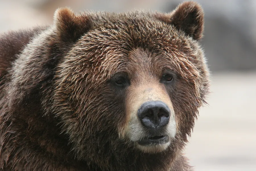

In [6]:
from fastdownload import download_url
dest = 'grizzly.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [24]:
searches = 'grizzly','black','teddy'
path = Path('bears')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} bear'))
    resize_images(path/o, max_size=400, dest=path/o)

SameFileError: Path('bears/grizzly/3ca3c060-07f3-4ae6-951a-8108e6f6b0a8.png') and Path('bears/grizzly/3ca3c060-07f3-4ae6-951a-8108e6f6b0a8.png') are the same file

In [17]:
fns = get_image_files(path)
fns

(#1145) [Path('bears/black/6704f3ba-771a-4a6e-9f05-cb3fa1b8334a.jpg'),Path('bears/black/2f127f7f-df53-44ea-95c9-8e53cf97fd55.jpg'),Path('bears/black/0b796b0e-0d05-4fc0-a1ae-c2259ccb1207.jpg'),Path('bears/black/60b3b2ae-db7a-40b0-8840-8ab88db796fc.jpg'),Path('bears/black/732800c2-ae40-4055-baa3-550ddb65e6e3.jpg'),Path('bears/black/863bdaf2-379e-42a7-beb0-9f46274bb58a.jpg'),Path('bears/black/27636e4e-2376-44b1-8acf-90bdcc089886.jpg'),Path('bears/black/743ebcda-f633-4a40-ad68-41e58c88d9ff.jpg'),Path('bears/black/6ed1e703-ec69-4279-883f-aa0dc5e59500.jpg'),Path('bears/black/9577badf-243d-481b-bb71-70da76fb1774.jpg')...]

In [18]:
failed = verify_images(fns)
failed

(#5) [Path('bears/black/af8f8fcd-b48d-4c2c-a6a7-f3dacb9096a1.jpg'),Path('bears/black/6dd2afc5-26ad-4ec9-a3fd-0e8b0bbba6f9.jpg'),Path('bears/black/bec01f42-b9a1-40d6-9c7b-6efa1ea14a2a.png'),Path('bears/grizzly/a379917a-1691-4ad5-a722-54de626f4dc9.jpg'),Path('bears/grizzly/26d0b7c4-9fc3-4f09-a0c2-8c0eb72b6eac.jpg')]

In [20]:
failed.map(Path.unlink);

FileNotFoundError: [Errno 2] No such file or directory: 'bears/black/af8f8fcd-b48d-4c2c-a6a7-f3dacb9096a1.jpg'

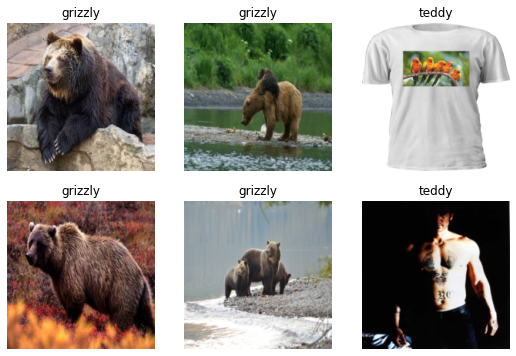

In [23]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [25]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/kh/mambaforge/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/home/kh/mambaforge/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.206276,0.307307,0.057018,01:01


epoch,train_loss,valid_loss,error_rate,time
0,0.318217,0.223235,0.043860,01:17
1,0.201057,0.278607,0.065789,01:16
2,0.132228,0.289811,0.057018,01:19


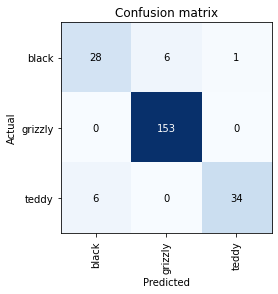

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

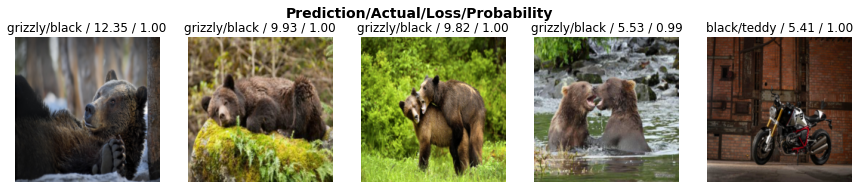

In [27]:
interp.plot_top_losses(5, nrows=1)

In [28]:
learn.export()

In [29]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [30]:
learn_inf = load_learner(path/'export.pkl')

In [32]:
learn_inf.predict('grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([9.4938e-04, 9.9718e-01, 1.8750e-03]))

In [33]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']